In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
from scipy.optimize import root
from volmodels import *
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,7),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
ONE_BP = 1e-4
ONE_PCT = 1e-2
N_STRIKES = 500

logmoneyness_lo = -1.5
logmoneyness_hi = 0.5

K_lo = 5*ONE_BP
K_hi = 4*ONE_PCT

In [4]:
xl = pd.ExcelFile('EUR_physical_vol_Jun19.xlsx')
df_1y = pd.read_excel(xl, sheet_name = 'expiry_1y', index_col='Strike')
df_10y = pd.read_excel(xl, sheet_name = 'expiry_10y')


In [5]:
df_1y

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,25Y,30Y
Strike,,,,,,,,,,,,,,
-150,27.09,30.91,34.79,36.93,38.84,40.62,39.33,40.55,41.49,42.33,43.80,45.13,45.32,45.22
-100,24.39,28.18,31.91,33.81,35.52,37.14,36.35,37.50,38.38,39.18,40.49,41.78,41.96,41.86
-50,21.05,25.02,28.87,30.80,32.55,34.19,34.44,35.66,36.60,37.44,38.86,40.22,40.40,40.30
-25,20.47,24.55,28.49,30.49,32.28,33.96,34.86,36.13,37.11,37.99,39.51,40.90,41.10,40.99
ATM,21.80,25.80,29.70,31.70,33.50,35.20,36.60,37.90,38.90,39.80,41.40,42.80,43.00,42.90
25,24.81,28.64,32.42,34.38,36.15,37.83,39.47,40.77,41.77,42.68,44.31,45.71,45.91,45.81
50,28.55,32.31,36.02,37.96,39.71,41.37,43.05,44.34,45.34,46.24,47.88,49.27,49.47,49.38
100,36.47,40.37,44.17,46.13,47.90,49.58,51.10,52.39,53.39,54.30,55.94,57.34,57.54,57.44
150,44.29,48.49,52.52,54.58,56.43,58.18,59.45,60.78,61.80,62.72,64.37,65.80,66.00,65.90


## Model

In [6]:
# model = SABR_Hagan_N(beta=.5, 
#                      marking_mode='sigma_0',
#                      sigma_0=20*ONE_PCT,
#                      n_strikes=N_STRIKES,
#                      logmoneyness_lo=logmoneyness_lo,
#                      logmoneyness_hi=logmoneyness_hi
#                     )

# init_params_map = {
#    'beta' : 0.5,
#    'sigma_0': 20*ONE_PCT,
#    'vov': 40*ONE_PCT,
#    'rho': -40*ONE_PCT,   
# }

# model = SABR_tanh_N(n_strikes=N_STRIKES,
#                     logmoneyness_lo=logmoneyness_lo, 
#                     logmoneyness_hi=logmoneyness_hi,
#                    )

# init_params_map = {
#    'l' : 1,
#    'sigma_0': 20*ONE_PCT,
#    'vov': 40*ONE_PCT,
#    'rho': -40*ONE_PCT,   
# }

model = SABR_AS_N(n_strikes=N_STRIKES,
                  K_lo=K_lo, 
                  K_hi=K_hi,
                  strike_type='strike'
                 )

init_params_map = {
    'c' : 1,
    'K_max': 20*ONE_BP,
    'sigma_0': 20*ONE_PCT,
    'vov': 40*ONE_PCT,
    'rho': -40*ONE_PCT,   
}

## Fitter

In [7]:
fitter = Fitter(model=model, init_params_map=init_params_map)

## Expiry 1y

In [8]:
T_expiry = 1
f = 2*ONE_PCT
df = df_1y

In [9]:
fitter.f = f
fitter.T_expiry = T_expiry
fitter.df = df

/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:236: RuntimeWarning: invalid value encountered in log
  C_f_avg_adj = np.exp(-self.c*np.log(f_avg_adj)**2)
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:238: RuntimeWarning: invalid value encountered in log
  gamma_1 = -(2*self.c*np.log(f_avg_adj))/f_avg
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:239: RuntimeWarning: invalid value encountered in log
  gamma_2 = (2*self.c*(-1+np.log(f_avg_adj)+2*self.c*np.log(f_avg_adj)**2))/(f_avg**2)
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:96: RuntimeWarning: invalid value encountered in log
  return (np.exp(-1/(4*self.c))*self.K_max*np.sqrt(np.pi)                *erfi((1+2*self.c*np.log(x/self.K_max))/(2*np.sqrt(self.c))))/(2*np.sqrt(self.c))
/home/sauxpa/Documents/python_scripts/Quant/diffusions

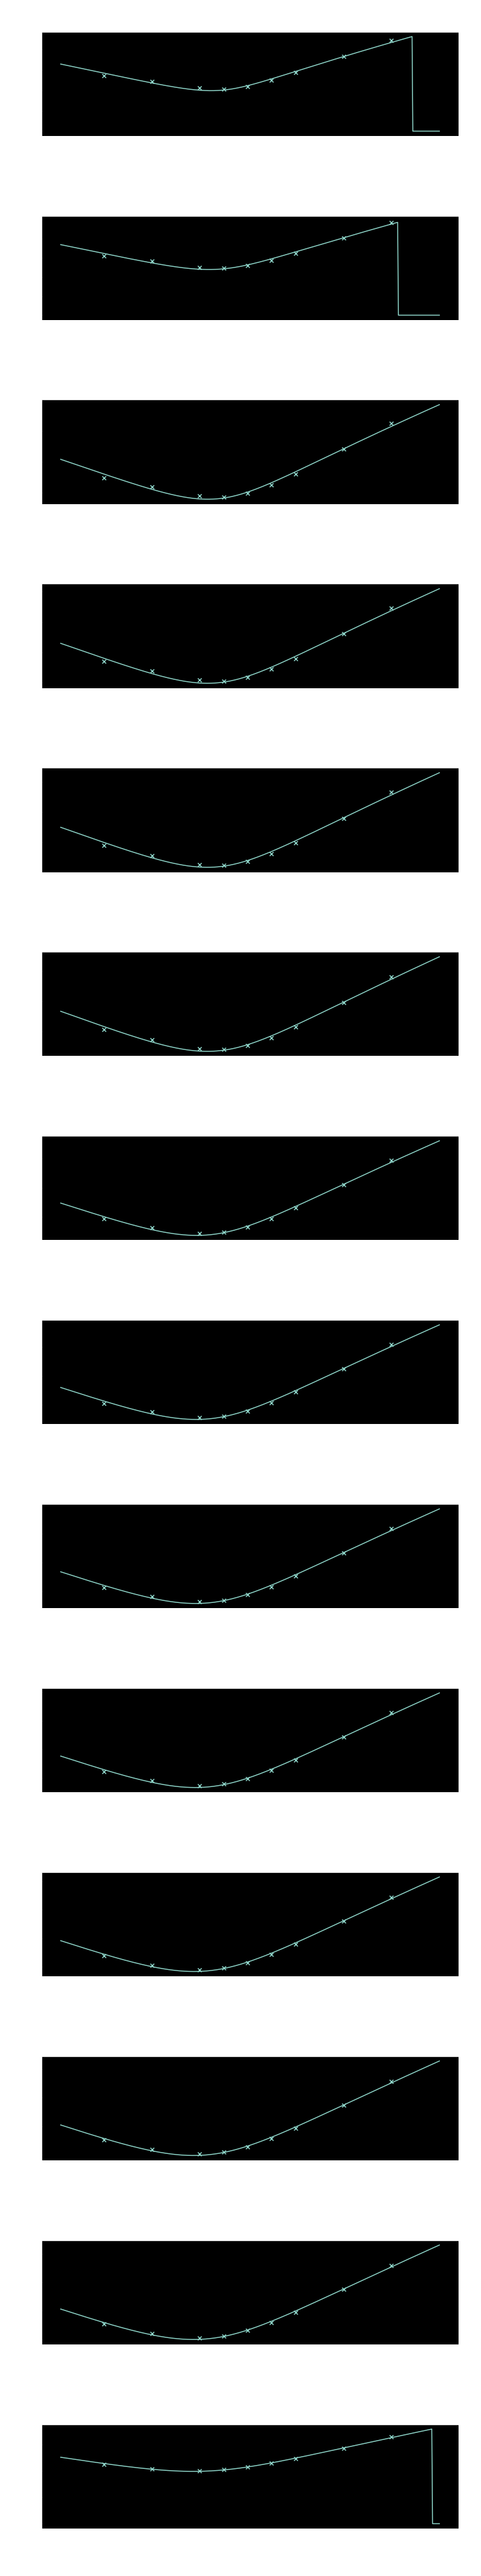

In [10]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

fig, axes = plt.subplots(figsize=(11, len(df.columns)*4), nrows=len(df.columns), ncols=1)

for tenor, ax in zip(df.columns, axes):
    fitter.tenor = tenor
    fitter.fit()
    model_fitted = fitter.calibrate_model()
    
    x_grid = model_fitted.strike_grid
    smile = list(model_fitted.smile.values())

    ax.plot(x_grid, smile)
    ax.scatter(fitter.market_smile.keys(), fitter.market_smile.values(), marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('tenor={}\n'.format(tenor)+ str(model_fitted))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

plt.tight_layout()
plt.show()

/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_base.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  d           = (f-K)/total_var


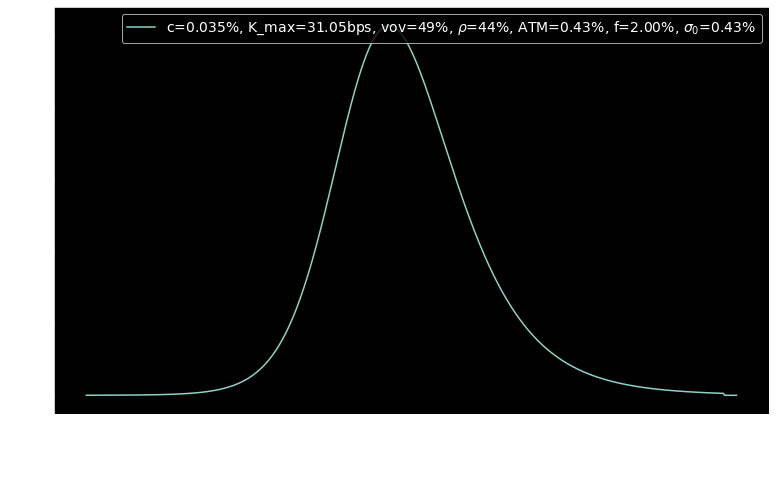

In [11]:
xlabel = 'logmoneyness\n\n'
ylabel = 'pdf'

fig, ax = plt.subplots(nrows=1, ncols=1)

x_grid = model_fitted.strike_grid
pdf = list(model_fitted.pdf_curve.values())

ax.plot(x_grid, pdf, label=str(model_fitted))

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Expiry 10y

In [12]:
T_expiry = 10
f = 3*ONE_PCT
df = df_1y

In [13]:
fitter.f = f
fitter.T_expiry = T_expiry
fitter.df = df

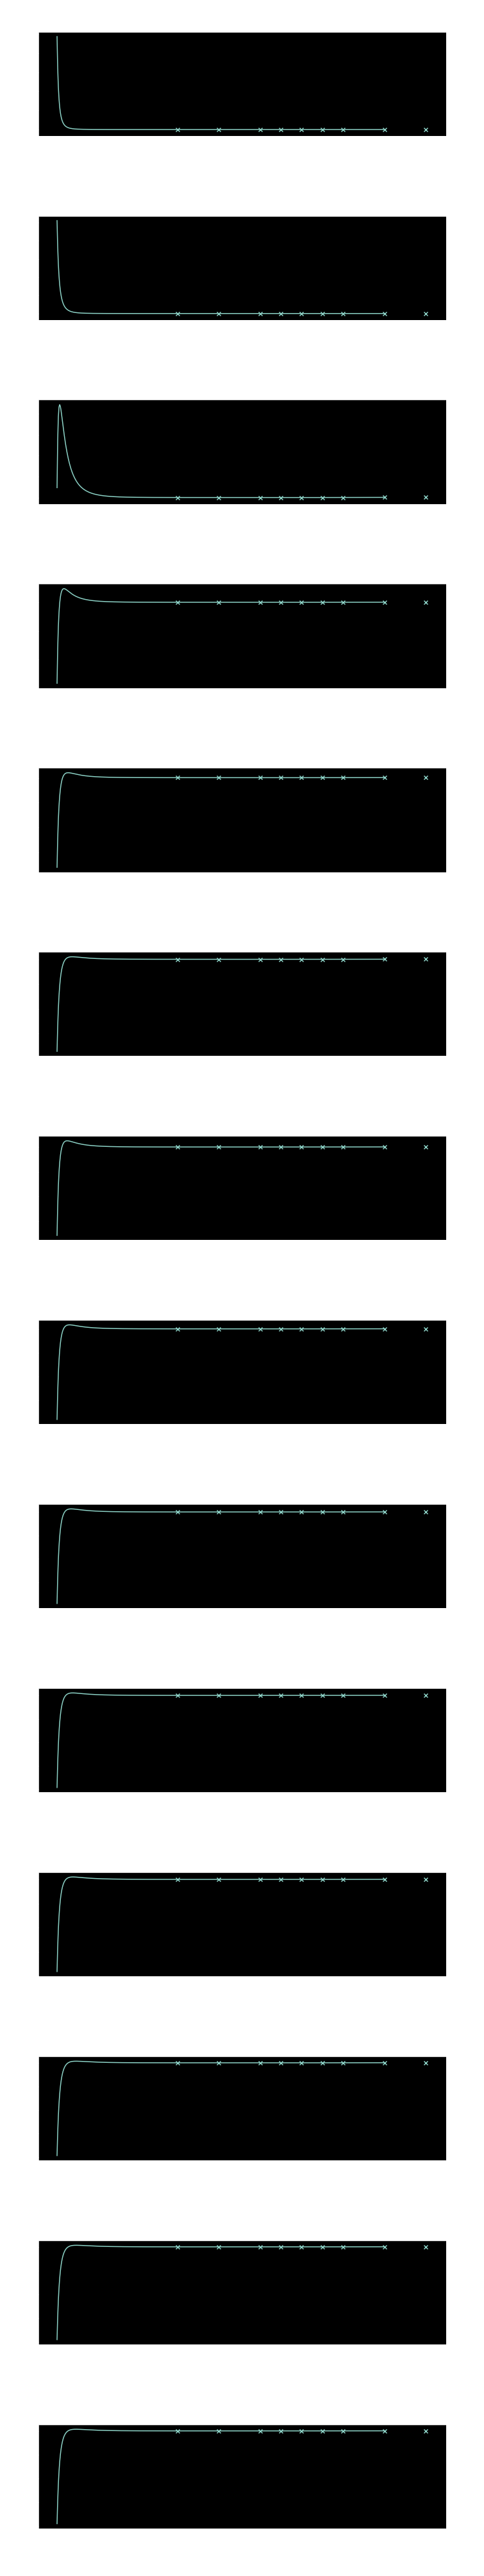

In [14]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

fig, axes = plt.subplots(figsize=(11, len(df.columns)*4), nrows=len(df.columns), ncols=1)

for tenor, ax in zip(df.columns, axes):
    fitter.tenor = tenor
    fitter.fit()
    model_fitted = fitter.calibrate_model()
    
    x_grid = model_fitted.strike_grid
    smile = list(model_fitted.smile.values())

    ax.plot(x_grid, smile)
    ax.scatter(fitter.market_smile.keys(), fitter.market_smile.values(), marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('tenor={}\n'.format(tenor)+ str(model_fitted))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

plt.tight_layout()
plt.show()

## Comparison between models

In [15]:
K_lo = 50*ONE_BP

model_SABR = SABR_Hagan_N(beta=.5, 
                          marking_mode='sigma_0', 
                          sigma_0=20*ONE_PCT,
                          n_strikes=N_STRIKES,
                          logmoneyness_lo=logmoneyness_lo,
                          logmoneyness_hi=logmoneyness_hi
                         )

init_params_map_SABR = {
    'beta' : 0.5,
    'sigma_0': 20*ONE_PCT,
    'vov': 40*ONE_PCT,
    'rho': -40*ONE_PCT,   
}

model_tanh = SABR_tanh_N(n_strikes=N_STRIKES,
                         logmoneyness_lo=logmoneyness_lo,
                         logmoneyness_hi=logmoneyness_hi
                        )

init_params_map_tanh = {
    'l' : 1,
    'sigma_0': 20*ONE_PCT,
    'vov': 40*ONE_PCT,
    'rho': -40*ONE_PCT,   
}

model_AS = SABR_AS_N(K_max=100*ONE_BP, 
                     c=0.5,
                     n_strikes=N_STRIKES, 
                     K_lo=K_lo,
                     K_hi=K_hi,
                     strike_type='strike'
                    )

init_params_map_AS = {
    #'c' : 0.1,
    #'K_max': 150*ONE_BP,
    'sigma_0': 50*ONE_BP,
    'vov': 40*ONE_PCT,
    'rho': -40*ONE_PCT,   
}

In [16]:
T_expiry = 1.0
tenor = '5Y'
f = 2*ONE_PCT
df = df_1y

fitter_SABR = Fitter(model=model_SABR, 
                     init_params_map=init_params_map_SABR,
                     df=df,
                     f=f,
                     T_expiry=T_expiry
                    )
fitter_tanh = Fitter(model=model_tanh,
                     init_params_map=init_params_map_tanh,
                     df=df, 
                     f=f,
                     T_expiry=T_expiry
                    )
fitter_AS = Fitter(model=model_AS,
                   init_params_map=init_params_map_AS,
                   df=df, 
                   f=f,
                   T_expiry=T_expiry
                  )

/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_tanh.py:85: RuntimeWarning: invalid value encountered in log
  return self.l*np.log(np.sinh(x/self.l))


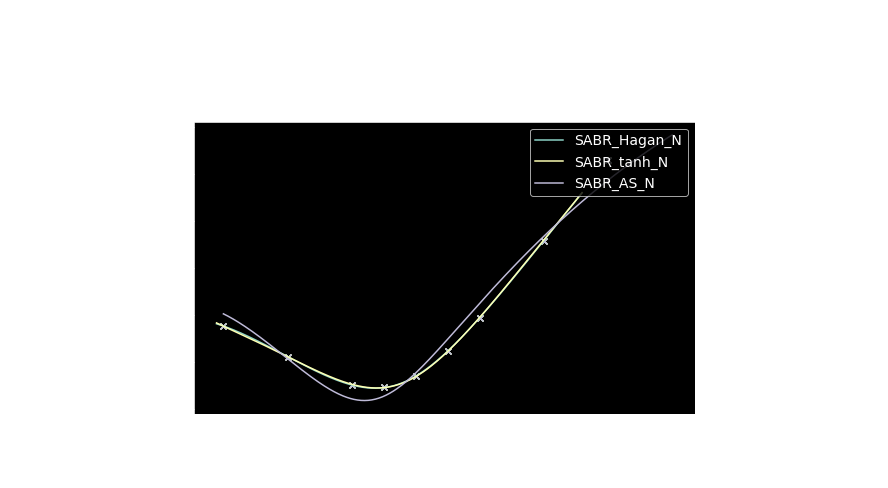

In [17]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

fig, ax= plt.subplots(nrows=1, ncols=1)

title = '{}\n'.format(tenor)

for fitter in [fitter_SABR, fitter_tanh, fitter_AS]:
    fitter.tenor = tenor
    fitter.fit()
    model_fitted = fitter.calibrate_model()
    
    x_grid = model_fitted.strike_grid
    smile = list(model_fitted.smile.values())

    ax.plot(x_grid, smile, label=model_fitted.model_name)
    ax.scatter(fitter.market_smile.keys(), fitter.market_smile.values(), marker='x')
    title += model_fitted.model_name + ': ' + str(model_fitted) + '\n'

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title(title)
ax.legend(loc='upper right')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

plt.tight_layout()
plt.show()

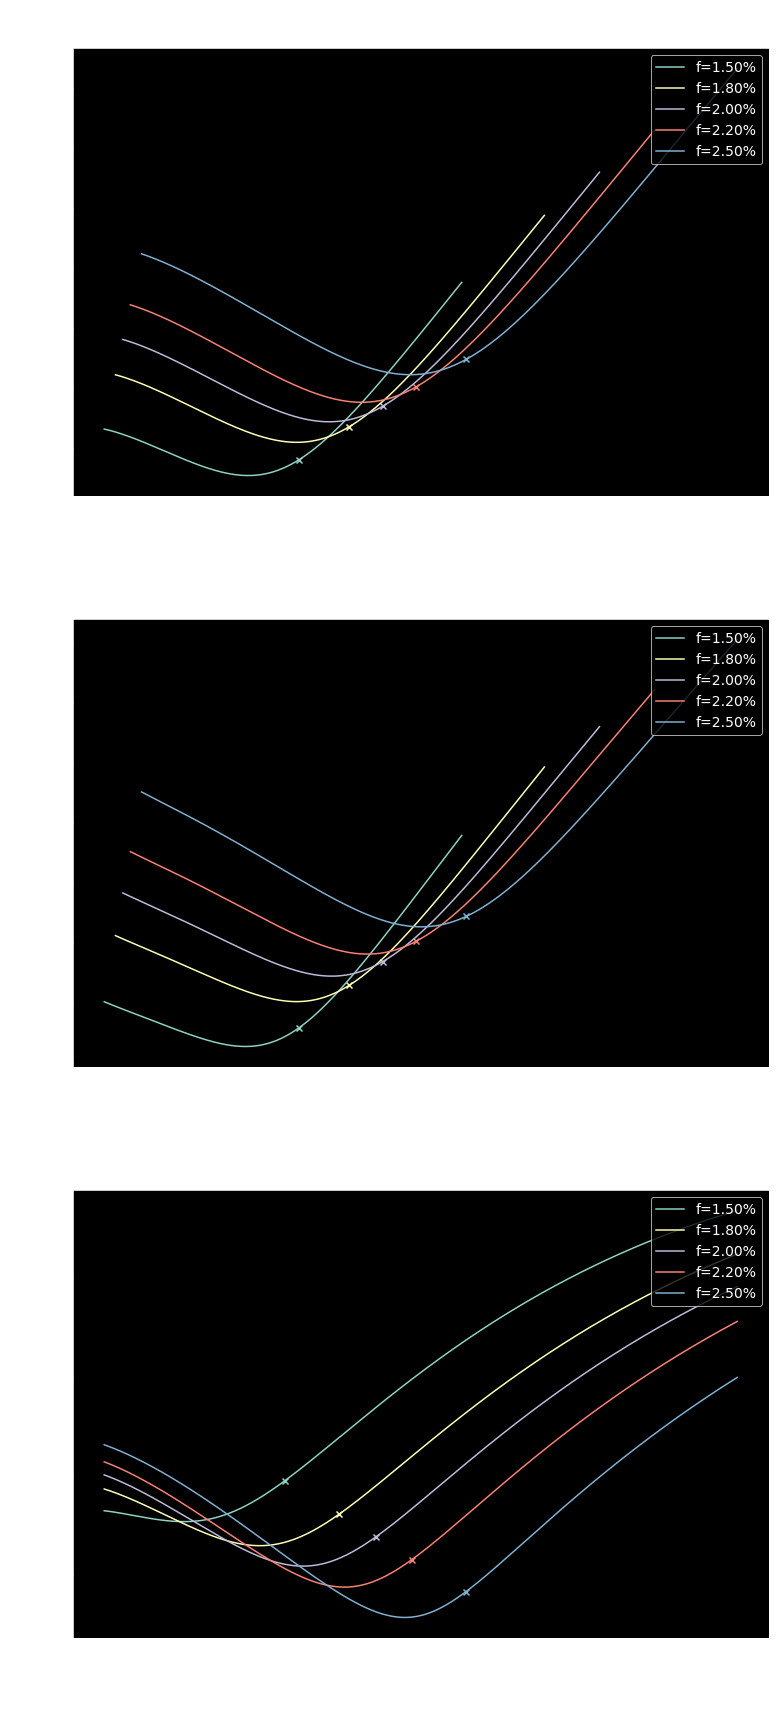

In [18]:
fig, axes = plt.subplots(figsize=(11, 24), nrows=3, ncols=1)

f_shocks = [
    -50*ONE_BP, 
    -20*ONE_BP, 
    0, 
    20*ONE_BP, 
    50*ONE_BP
]

for ax, fitter in zip(axes, [fitter_SABR, fitter_tanh, fitter_AS]):
    fitter.tenor = tenor
    fitter.fit()
    model_fitted = fitter.calibrate_model()
    
    for f_shock in f_shocks:
        model_fitted.f = f+f_shock
        smile = list(model_fitted.smile.values())
        label = 'f={:.2%}'.format(f+f_shock)
        ax.plot(model_fitted.strike_grid, smile, label=label)
        ax.scatter([model_fitted.f], [model_fitted.ATM], marker='x')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
        ax.set_title('{} {}Y into {} backbone\n'.format(model_fitted.model_name,\
                                                        model_fitted.T_expiry,\
                                                        tenor))

plt.tight_layout()
plt.show()